# notebook imagenette
The basis is kaiming initialization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## Imagenette data

In [4]:
#path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path = Path("/Users/kasparlund/.fastai/data/imagenette-160")

In [5]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)

train_dl,valid_dl = ( DataLoader(ll.train, batch_size=bs,   num_workers=4, shuffle=True),
                      DataLoader(ll.valid, batch_size=bs*2, num_workers=4))
data = DataBunch(train_dl, valid_dl, c_in=3, c_out=max(ll.train.y)+1)
print(len(train_dl))

101


In [6]:
#layers_sizes = [32,64,128,256,512]
layers_sizes = [64,64,128,256]
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs_base = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#        partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
        partial(MixUp,α=0.4),
        
        #CudaCallback,
        ProgressCallback,
       ]
cbfs = cbfs_base.copy() + [Recorder, partial(AvgStatsCallback,[accuracy])]
cbfs_lr_Finder = cbfs_base.copy() + [LR_Finder]

## steppers=[sgd_step]

In [8]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=SGD(sched,max_lr=0.1), cb_funcs=cbfs)
%time learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.123557,0.266946,1.816653,0.422000,01:42


CPU times: user 6min 43s, sys: 1min 15s, total: 7min 59s
Wall time: 1min 42s


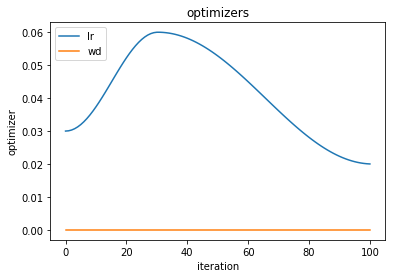

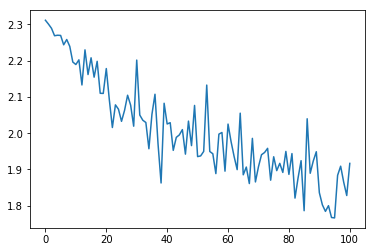

(None, None)

In [9]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()


## steppers=[weight_decay, sgd_step]

In [10]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=SGD(sched,max_lr=0.1, max_wd=1e-4), cb_funcs=cbfs)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
%time learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.989462,0.294478,1.772617,0.396000,01:33


CPU times: user 6min 40s, sys: 1min 9s, total: 7min 49s
Wall time: 1min 33s


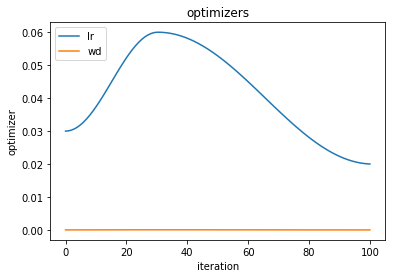

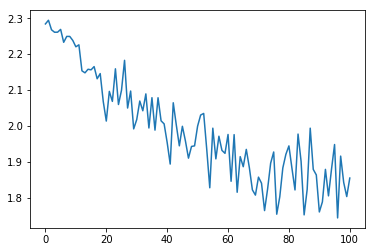

(None, None)

In [11]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [12]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                opt=SGD_Momentum(sched,max_lr=0.08, moms=(0.85,0.95), max_wd=1e-4 ), cb_funcs=cbfs)
%time learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.027765,0.283931,1.828736,0.360000,01:31


CPU times: user 6min 34s, sys: 1min 7s, total: 7min 42s
Wall time: 1min 31s


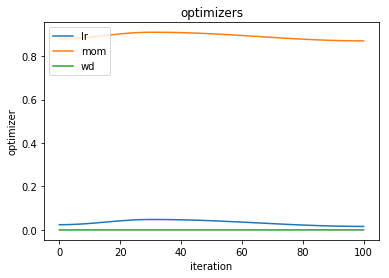

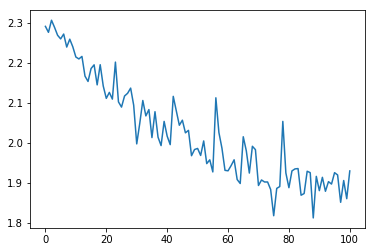

(None, None)

In [13]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam: steppers=[adam_step]

In [17]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=Adam(sched,max_lr=3e-4, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
%time learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.056677,0.307895,1.726178,0.440000,01:34
1,1.883512,0.417714,1.528182,0.506000,01:31
2,1.763584,0.482007,1.385362,0.572000,01:32
3,1.663015,0.535055,1.260506,0.622000,01:32
4,1.595846,0.575617,1.205952,0.642000,01:32
5,1.535950,0.603226,1.147372,0.660000,01:35
6,1.491761,0.627967,1.147350,0.654000,01:32
7,1.463825,0.642314,1.106420,0.662000,01:32
8,1.431768,0.659454,1.098543,0.668000,01:32
9,1.416805,0.668916,1.094908,0.676000,01:32


CPU times: user 1h 6min 30s, sys: 11min 38s, total: 1h 18min 9s
Wall time: 15min 28s


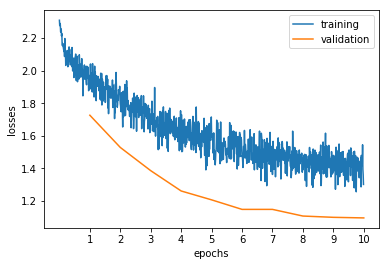

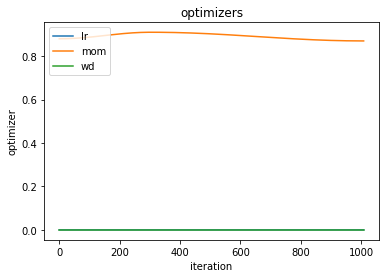

(None, None)

In [18]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=15),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## LAMB: steppers=[lamb_step]

In [16]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy,
                 opt=LAMB(sched,max_lr=3e-3, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
%time learn.fit(3)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.794000,0.385451,1.427905,0.508000,01:40
1,1.329187,0.566000,1.189193,0.634000,01:31
2,1.094054,0.649062,1.049857,0.674000,01:31


CPU times: user 20min 5s, sys: 3min 47s, total: 23min 52s
Wall time: 4min 43s


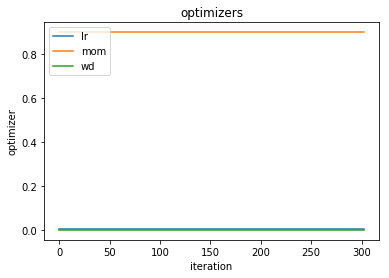

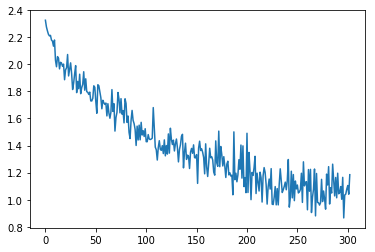

(None, None)

In [17]:
#learn.find_subcription_by_cls(LR_Finder).plot_loss(skip_end=17),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam with hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.945673,0.330696,1.741012,0.426000,01:41


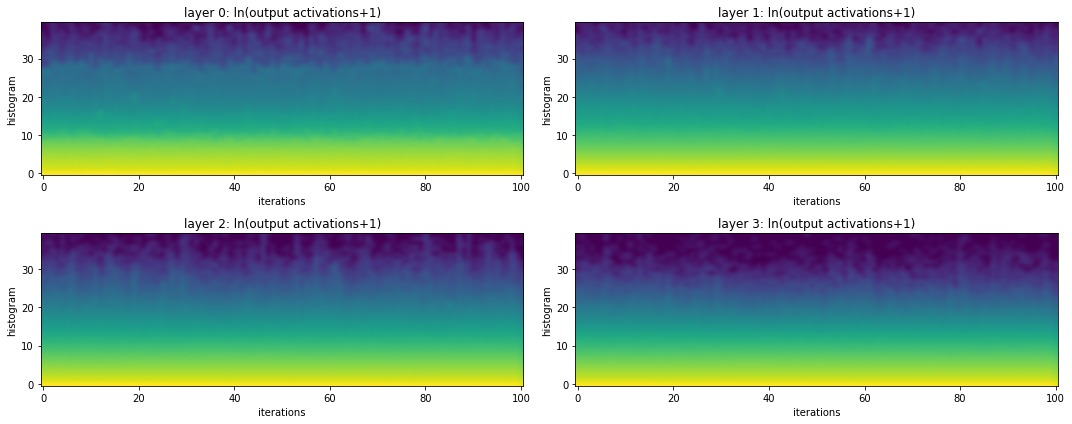

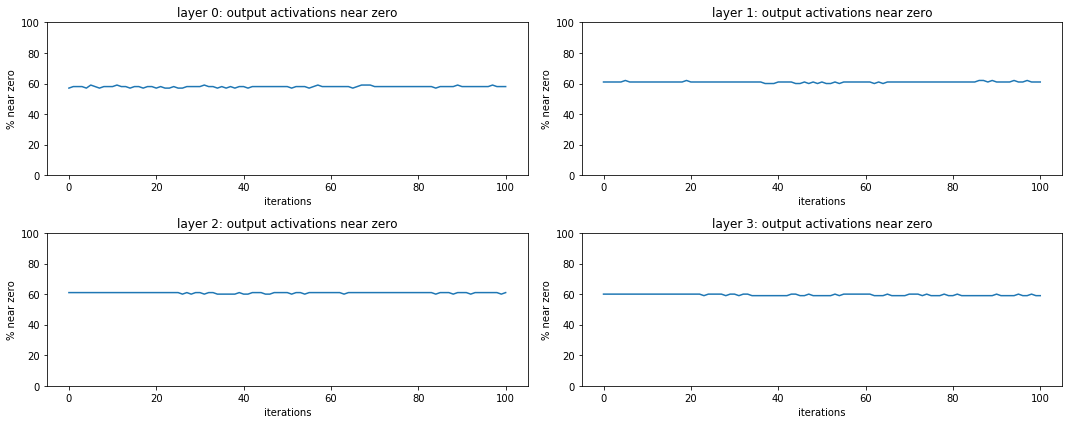

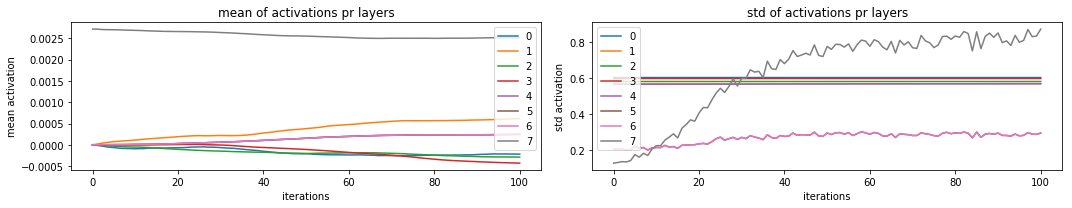

In [18]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=Adam(sched,max_lr=2e-4, moms=(0.85,0.95), max_wd = 1e-4), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )

## LAMB with hooks

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.662241,0.430355,1.561418,0.502000,01:43


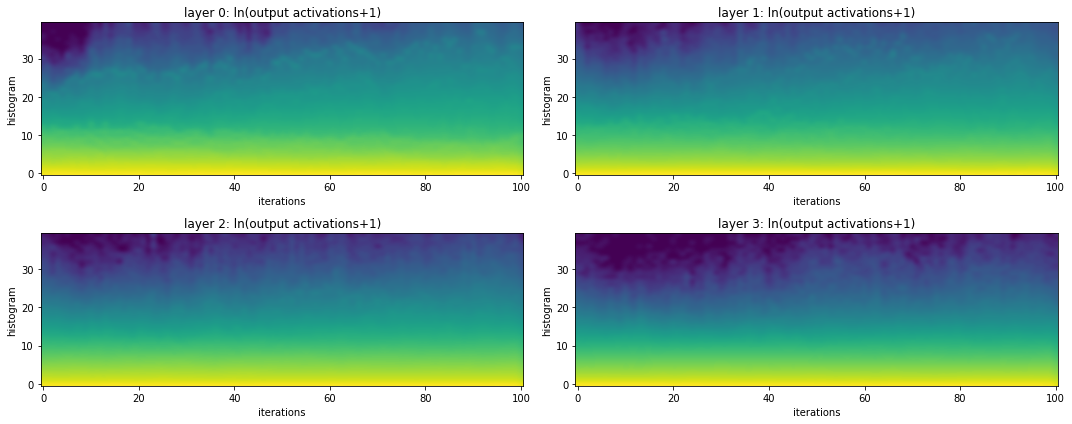

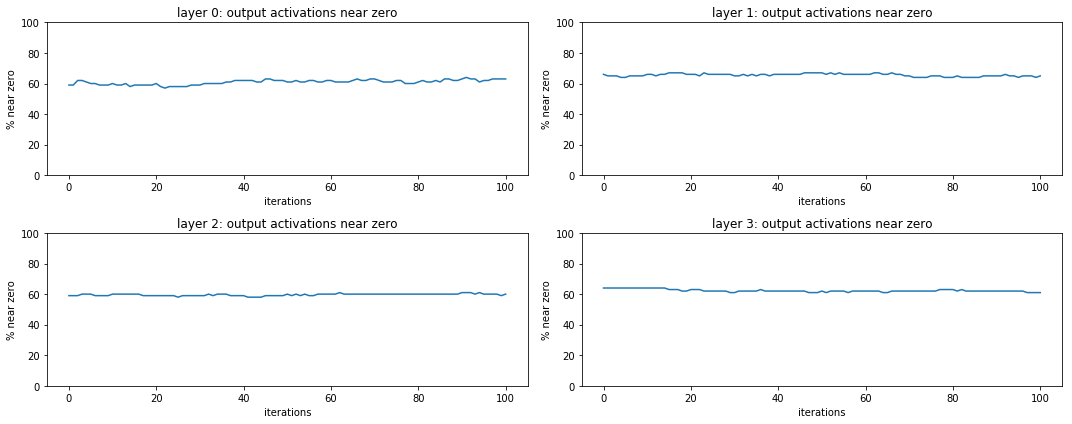

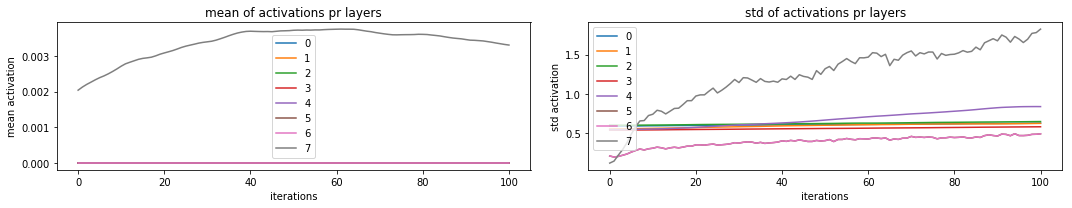

In [19]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, partial(conv_layer, stride=2) )
init_cnn( model )
learn = Learner( model, data, loss_func=F.cross_entropy, 
                 opt=LAMB(sched,max_lr=1e-2, moms=(0.85,0.95), max_wd = 1e-6), cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )